
# Social and normal calls classification using Random Forest

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from util.bat import *
import random
import os
import pandas as pd

# Set some Pandas options
pd.set_option('notebook_repr_html', True)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)


Find samples for normal valid pulses:

In [3]:
# datadir='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2015\\cell-0\\'
# valid_pulses,metadata,filenames=bulk_processing(datadir)
# len(valid_pulses) #294
# display_pulses(valid_pulses,49,7,figsize=(12,10),rand_flag=True)

In [4]:
# the zc files in this folder has no abnormal labels
datadir2='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2015\\cell-12\\'
valid_pulses2,metadata2,filenames2=bulk_processing(datadir2)
len(valid_pulses2) #161 pulses after remove noise and pulse extraction

161

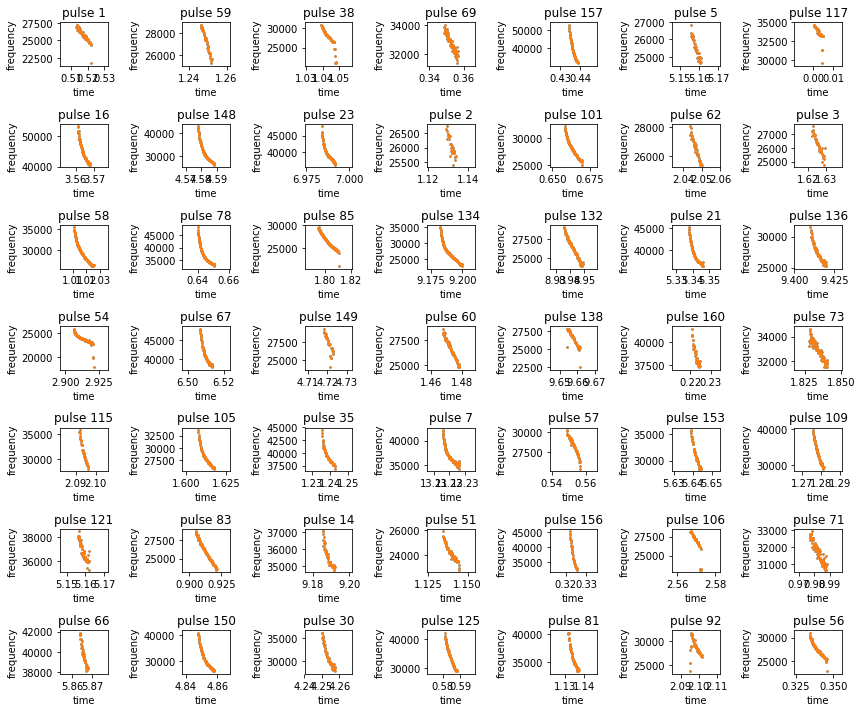

In [5]:
# Display normal pulses with random sample. Almost all the pulse has the similar shape.
display_pulses(valid_pulses2,49,7,figsize=(12,10),rand_flag=True)

In 2015 folder, we have 13 files labeled 'social'. So, let's use get_labeled_file method to find all the 'social' labeled files and get the time, frequency information from them.

In [6]:
datadir='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2015\\'
label='social'
lfiles=get_labeled_file(datadir,label)
len(lfiles)#13

No handlers could be found for logger "util.bat"


13

Then, use cluster_pulses method to get all the noise removed pulses from 13 files and perform K-Means with 3 clusters. We get 188 valid pulses in total. There are 104 pulses in Cluster 0, 58 pulses in Cluster 1 and 26 pulses in Cluster 3. From the visualization below, we can see that most of the special call shape appear in Cluster 0 and most of the pulses in Cluster 1 and 2 are normal.

In [9]:
features,y_kmeans,pulses=cluster_pulses(lfiles,3)
len(pulses)

188

In [10]:
sum(y_kmeans==0)

104

In [11]:
sum(y_kmeans==1)

58

In [12]:
sum(y_kmeans==2)

26

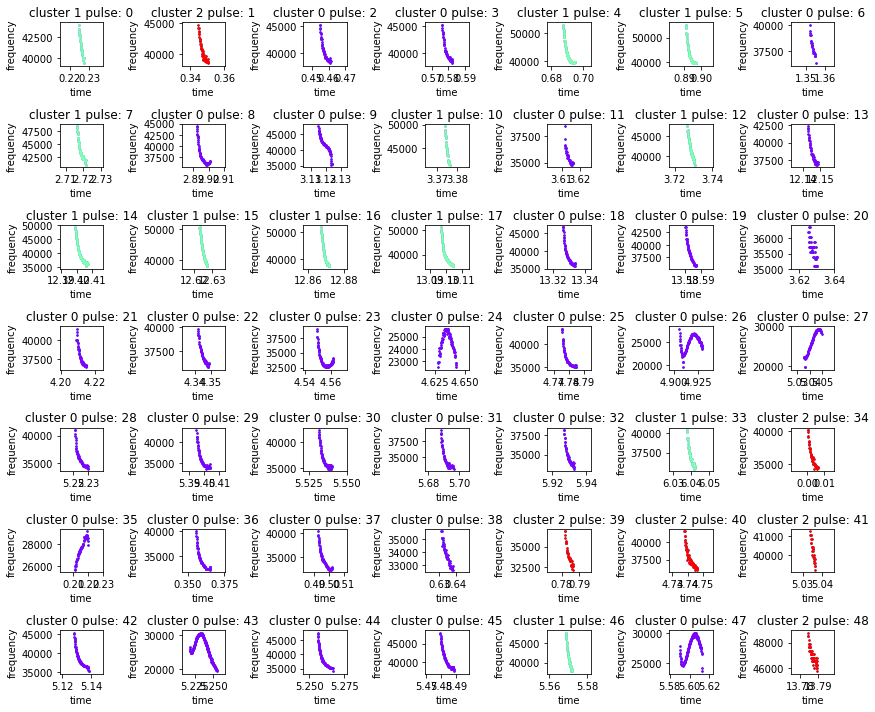

In [13]:
display_pulses(pulses[0:49],49,7,figsize=(12,10),rand_flag=False, cluster=y_kmeans)

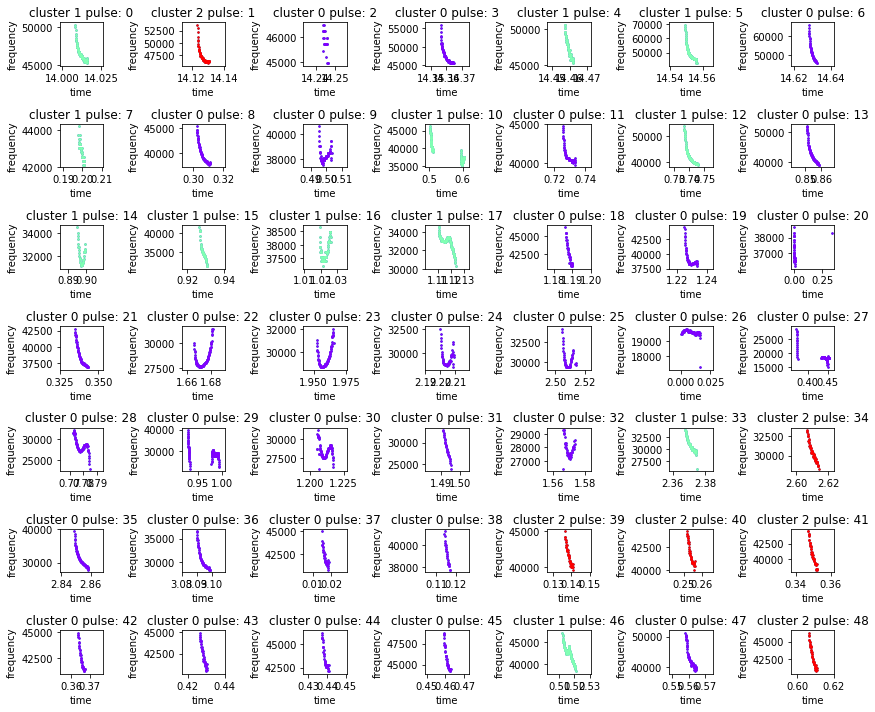

In [14]:
display_pulses(pulses[49:98],49,7,figsize=(12,10),rand_flag=False, cluster=y_kmeans)

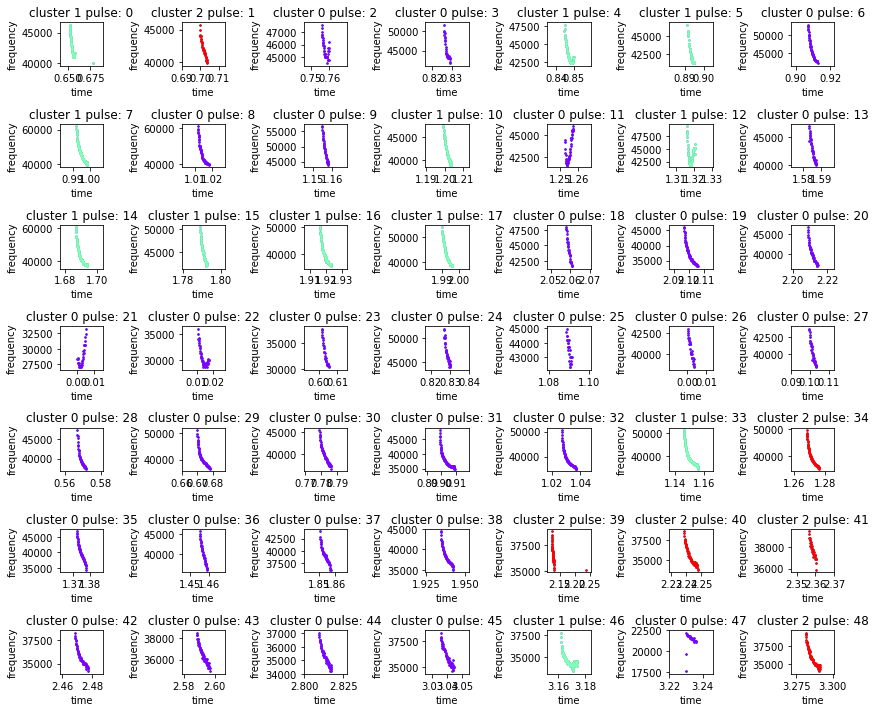

In [15]:
display_pulses(pulses[98:147],49,7,figsize=(12,10),rand_flag=False, cluster=y_kmeans)

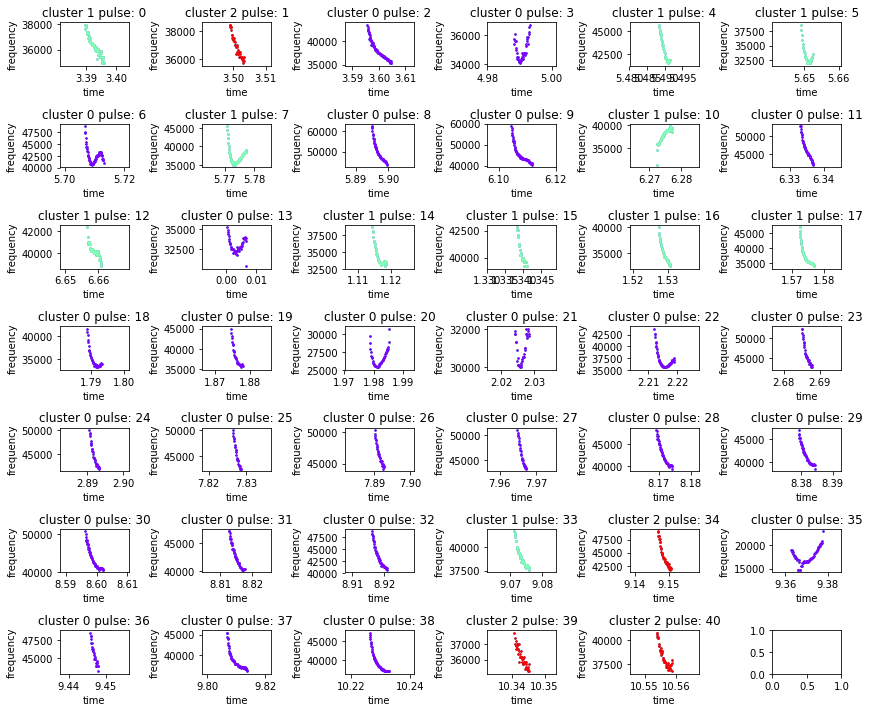

In [16]:
display_pulses(pulses[147:],len(pulses)-147,7,figsize=(12,10),rand_flag=False, cluster=y_kmeans)

Based on Clustering results, I further manually labeled obvious abnormal calls. They are index are:9,23,24,26,27,35,43,47,58,68,69,71,72,73,74,75,76,77,78,79,81,59,63,65,66,95,100,109,119,110,137,150,153,156,160,167,168,169,182,152,154,157,159. 
 
Here is a summary table for the probability of obvious abnormal calls in each Cluster, indicating clustering method can actually detect some abnormal calls among normal calls which further help us labeling abnormal pulses with spcialist knowledge.
 


Now, our sample observation is coming from the combination of 161 normal pulses and 43 abnormal pulses after noise removal. Response variable y is a categorical variable: 0 stands for normal and 1 stands for social. Next, let's get features of our samples. 

In [19]:
b=[9,23,24,26,27,35,43,47,58,68,69,71,72,73,74,75,76,77,78,79,81,59,63,65,66,95,100,109,119,110,137,150,153,156,160,167,168,169,182,152,154,157,159]
pulses = np.array(pulses)
# len(pulses[b])
social_pulse=list(pulses[b])
# obs=valid_pulses+social_pulse
# len(obs)#337=294+43
obs2=valid_pulses2+social_pulse
len(obs2)

204

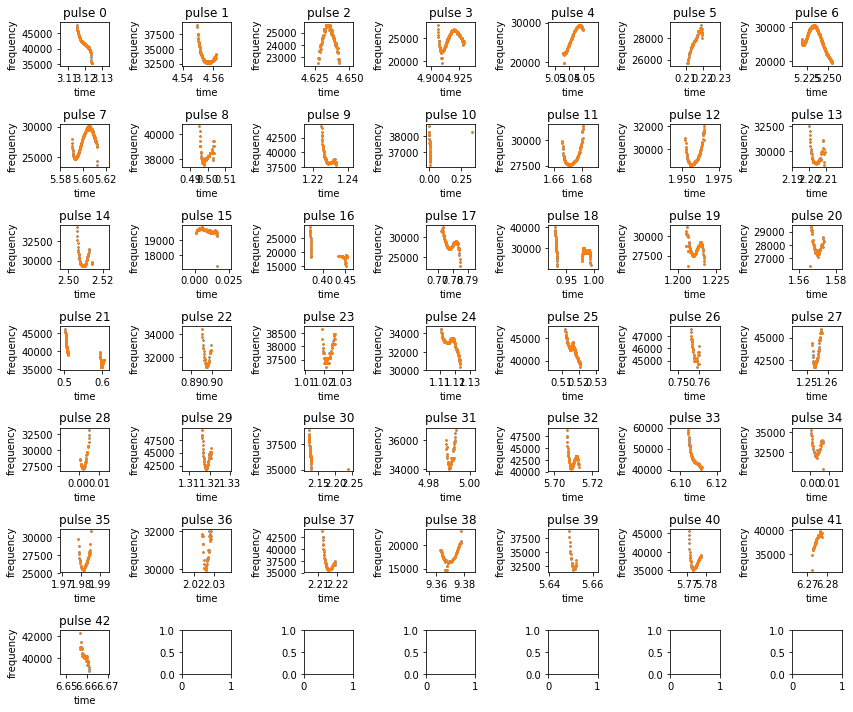

In [20]:
# display all selected obvious social pulses
display_pulses(social_pulse,43,7,figsize=(12,10),rand_flag=False)

In [21]:
# response variable--labeled data
y2=[0]*161+[1]*43
len(y2)

204

In [22]:
b,c=get_dy_dy2(obs2)
bf=get_features(b)
cf=get_features(c)
ff=pd.concat([bf.iloc[:,3:6], cf.iloc[:,3:6]], axis=1)
ff2=pd.concat([bf, cf], axis=1)
ff3=pd.concat([bf.iloc[:,[0,1,3,4,5]], cf.iloc[:,[0,1,3,4,5]]], axis=1)

In [23]:
# ff3.head()
# ff2.head()
ff.head()

25%        50%         75%         25%           50%         75%
0 -167.574361 -42.613473   89.340272 -251.632698  3.637979e-12  177.779753
0 -182.339415 -80.130612   82.012102 -162.786718  0.000000e+00  114.195326
0 -156.599044   0.000000   65.138093 -123.673091  0.000000e+00  167.574361
0 -112.907331 -63.190828    0.000000 -119.796346  0.000000e+00   80.881610
0 -241.113946 -39.931318  160.232337 -164.230394  8.413630e+01  214.976077

Split our sample to training and test set using 7:3 proportion. Try different feature combinations in random forest classification. It turns out the Quantile 1, median and Quantile 3 for dy and dy2 yield the best classification accuracy(90%):

In [24]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
X=ff
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y2,test_size=0.3,train_size=0.7, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
metrics.accuracy_score(ypred, ytest)

0.9032258064516129

In [26]:
metrics.confusion_matrix(ypred, ytest)

array([[49,  5],
       [ 1,  7]], dtype=int64)

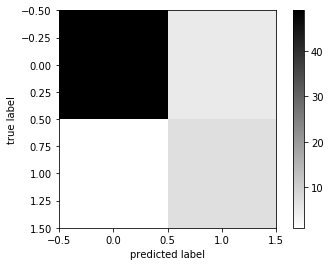

In [27]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

In [28]:
print metrics.classification_report(ypred, ytest)

             precision    recall  f1-score   support

          0       0.98      0.91      0.94        54
          1       0.58      0.88      0.70         8

avg / total       0.93      0.90      0.91        62



In [29]:
clf.feature_importances_

array([0.17092807, 0.35517261, 0.14109672, 0.16678306, 0.03383428,
       0.13218526])

In [30]:
a=[0.17092807, 0.35517261, 0.14109672, 0.16678306, 0.03383428,
       0.13218526]
objects = ('dy_Q1', 'dy_median', 'dy_Q3','dy2_Q1', 'dy2_median', 'dy2_Q3')
y_pos = np.arange(len(objects))

Text(0.5,1,'Feature Importance')

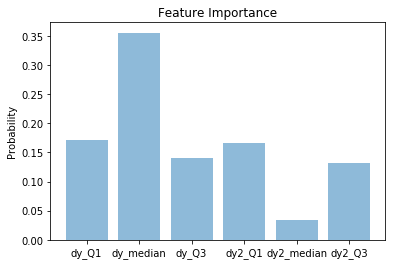

In [31]:
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Probability')
plt.title('Feature Importance')

In [32]:
# decision tree

# from sklearn.cross_validation import train_test_split
# from sklearn import metrics
# from sklearn import tree
# model = tree.DecisionTreeClassifier(max_depth=10)
# X=ff
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y2,test_size=0.3,train_size=0.7, random_state=0)
# # clf = DecisionTreeClassifier(max_depth=10)
# model.fit(Xtrain, ytrain)
# ypred = model.predict(Xtest)
# metrics.accuracy_score(ypred, ytest)
# metrics.confusion_matrix(ypred, ytest)

# plt.imshow(metrics.confusion_matrix(ypred, ytest),
#            interpolation='nearest', cmap=plt.cm.binary)
# plt.grid(False)
# plt.colorbar()
# plt.xlabel("predicted label")
# plt.ylabel("true label");

# print metrics.classification_report(ypred, ytest)
# model.feature_importances_